In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
from prophet import Prophet
from sklearn.metrics import  mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Preparing the Data

### Read Data

In [101]:
data_path = '../Data/Electric_Consumption.csv'
df=pd.read_csv(data_path)

print(df.shape)
df.head()

(521035, 27)


,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800.0,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200.0,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200.0,5919.55,216.0,2808.0,5177.43
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14764.04,GOV/NYC/068,Yes,105600.0,6057.22,208.0,2704.0,6002.82
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13729.54,GOV/NYC/068,Yes,97600.0,5598.34,216.0,2808.0,5323.20


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521035 entries, 0 to 521034
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    520414 non-null  object 
 1   Borough             521035 non-null  object 
 2   Account Name        521035 non-null  object 
 3   Location            507102 non-null  object 
 4   Meter AMR           520266 non-null  object 
 5   Meter Scope         27636 non-null   object 
 6   TDS #               519157 non-null  float64
 7   EDP                 521035 non-null  int64  
 8   RC Code             521035 non-null  object 
 9   Funding Source      521035 non-null  object 
 10  AMP #               518672 non-null  object 
 11  Vendor Name         521035 non-null  object 
 12  UMIS BILL ID        521035 non-null  int64  
 13  Revenue Month       521035 non-null  object 
 14  Service Start Date  521027 non-null  object 
 15  Service End Date    521027 non-nul

In [103]:
df['Service End Date'].nunique()

1053

In [104]:
df['Location'].nunique()

536

The data was collected seperatly by `location`. For completenece, we chose to aggregate the data using `mean()` over the 5 different Boroughs. Since the number of buildings (i.e, `location`) doesn't represent the entire NYC area.

In [105]:
# convert to datetime and rename columns
df['Service Start Date'] = pd.to_datetime(df['Service Start Date'])
df['ds'] = pd.to_datetime(df['Service End Date'])
df['y'] = df['Consumption (KWH)']

# set Date as index
df.set_index('ds', inplace=True)
df_ts = df[['y']].copy()

## Resampling - Monthly and Yearly

In [106]:
# resampling to monthly end date
df_monthly = df_ts.resample('ME').mean()
df_monthly = df_monthly[:-1] # remove last month (January 2025, which has no data)
df_monthly.index.freq = pd.infer_freq(df_monthly.index)
df_monthly = df_monthly.reset_index()
df_monthly.head()

,ds,y
0,2010-01-31,45446.030782
1,2010-02-28,38824.279283
2,2010-03-31,36652.063380
3,2010-04-30,36823.726747
4,2010-05-31,36918.425453


In [107]:
# resampling to yearly end date
df_yearly = df_ts.resample('YE').mean()
df_yearly = df_yearly[:-1] # remove last month (2025, which has no data)
df_yearly.index.freq = pd.infer_freq(df_yearly.index)
df_yearly = df_yearly.reset_index()
df_yearly.head()

,ds,y
0,2010-12-31,44608.503400
1,2011-12-31,150980.000000
2,2012-12-31,36346.207317
3,2013-12-31,32702.755515
4,2014-12-31,30694.267709


In [108]:
# save monthly and yearly data
df_monthly.to_csv('../Data/df_monthly.csv')
df_yearly.to_csv('../Data/df_yearly.csv')

# EDA

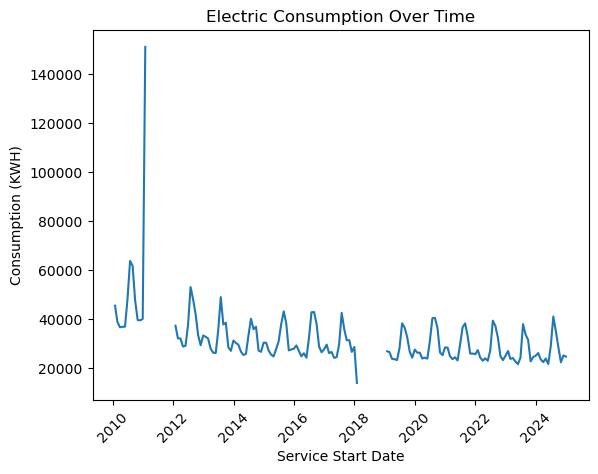

In [109]:
plt.ylabel('Consumption (KWH)')
plt.xlabel('Service Start Date')
plt.title('Electric Consumption Over Time')
plt.plot(df_monthly['ds'], df_monthly['y'])
plt.xticks(rotation=45)
plt.show()

In [110]:
#TODO: decomposing the time series
# def decompose_time_series(df):
#     result = seasonal_decompose(df, model='additive')
#     result.plot()
#     plt.show()

# # decompose_time_series(df_monthly)
# decompose_time_series(df_monthly)
# decompose_time_series(df_yearly)

# Prophet Predictions

In [ ]:
def preprocess_and_split(df):
    """
    Preprocesses and splits the data into training and validation sets.
    This functon will be used for monthly dataset.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        tuple: A tuple containing the training and validation DataFrames.
    """
    # convert date to datetime if needed
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds').reset_index(drop=True)

    # drop rows with missing target values
    df = df.dropna(subset=['y'])

    # apply split
    train_df = df[(df['ds'] >= '2012-01-01') & (df['ds'] <= '2017-12-31')].copy()
    val_df = df[(df['ds'] >= '2019-01-01') & (df['ds'] <= '2024-12-31')].copy()

    return train_df, val_df


In [210]:
train_monthly_df, val_monthly_df = preprocess_and_split(df_monthly)

In [211]:
# # initialize and fit prophet model
# model = Prophet()
# model.fit(train_monthly_df)

# # forecast 9 months into the future
# future = model.make_future_dataframe(periods=9, freq='M')
# forecast = model.predict(future)

# # extract forecast points only

# # stitch last historical point to forecasted future for better visualization
# last_hist_point = train_monthly_df[['ds', 'y']].iloc[-1]
# last_point_df = pd.DataFrame({'ds': [last_hist_point['ds']], 'yhat': [last_hist_point['y']]})
# forecast_future = forecast[forecast['ds'] > train_monthly_df['ds'].max()].reset_index(drop=True)
# forecast_line = pd.concat([last_point_df, forecast_future[['ds', 'yhat']]], ignore_index=True)

# # plot historical data
# plt.figure(figsize=(12, 6))
# plt.plot(train_monthly_df['ds'], train_monthly_df['y'], color='black', label='Historical')

# # plot stitched forecast in 3 colored segments
# plt.plot(forecast_line['ds'].iloc[0:2], forecast_line['yhat'].iloc[0:2], color='green', label='Forecast: 1 month')
# plt.plot(forecast_line['ds'].iloc[1:6], forecast_line['yhat'].iloc[1:6], color='orange', label='Forecast: 2–6 months')
# plt.plot(forecast_line['ds'].iloc[5:], forecast_line['yhat'].iloc[5:], color='red', label='Forecast: 7–9 months')

# # confidence interval
# plt.fill_between(forecast_future['ds'],
#                  forecast_future['yhat_lower'],
#                  forecast_future['yhat_upper'],
#                  color='gray', alpha=0.2, label='Confidence Interval')

# # aesthetics
# plt.title('Electricity Consumption Forecast (Monthly)')
# plt.xlabel('Date')
# plt.ylabel('Electric Consumption')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [212]:
# # define and fit the model
# model_yearly = Prophet(growth='linear')
# model_yearly.fit(df_yearly)

# # forecast 20 years into the future
# future_years = model_yearly.make_future_dataframe(periods=20, freq='Y')
# forecast_yearly = model_yearly.predict(future_years)

# # extract forecasted portion
# forecast_future = forecast_yearly[forecast_yearly['ds'] > df_yearly['ds'].max()].reset_index(drop=True)

# # stitch last historical point to forecast
# last_hist_point = df_yearly[['ds', 'y']].iloc[-1]
# last_point_df = pd.DataFrame({'ds': [last_hist_point['ds']], 'yhat': [last_hist_point['y']]})
# forecast_line = pd.concat([last_point_df, forecast_future[['ds', 'yhat']]], ignore_index=True)

# # plot historical data
# plt.figure(figsize=(12, 6))
# plt.plot(df_yearly['ds'], df_yearly['y'], color='black', label='Historical')

# # segment forecast line: 1, 2–10, 11–20 years
# plt.plot(forecast_line['ds'].iloc[0:2], forecast_line['yhat'].iloc[0:2], color='green', label='Forecast: 1 year')
# plt.plot(forecast_line['ds'].iloc[1:11], forecast_line['yhat'].iloc[1:11], color='orange', label='Forecast: 2–10 years')
# plt.plot(forecast_line['ds'].iloc[10:], forecast_line['yhat'].iloc[10:], color='red', label='Forecast: 11–20 years')

# # confidence interval
# plt.fill_between(forecast_future['ds'],
#                  forecast_future['yhat_lower'],
#                  forecast_future['yhat_upper'],
#                  color='gray', alpha=0.2, label='Confidence Interval')

# # aesthetics
# plt.title('Electricity Consumption Forecast (Yearly)')
# plt.xlabel('Year')
# plt.ylabel('Electric Consumption')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
# def detect_time_frequency(df):
#     """
#     Detect whether the time series is monthly or yearly based on data frequency.
    
#     Args:
#         df (pd.DataFrame): Input dataframe with 'ds' column containing dates
        
#     Returns:
#         str: 'monthly' or 'yearly'
#     """
#     if df['ds'].dt.freq == 'ME':
#         return 'monthly'
#     elif df['ds'].dt.freq == 'YE-DEC':
#         return 'yearly'
#     else:
#         return '0'


# def train_prophet_model(df, frequency):
#     """
#     Train a Prophet model based on the detected frequency
    
#     Args:
#         df (pd.DataFrame): Training dataframe with 'ds' and 'y' columns
#         frequency (str): 'monthly' or 'yearly'
        
#     Returns:
#         Prophet: Fitted Prophet model
#     """
#     if frequency == 'yearly':
#         model = Prophet(growth='linear')
#     else:  # monthly
#         model = Prophet()
    
#     model.fit(df)
#     return model

# def make_forecast(model, df, frequency):
#     """
#     Generate forecast using the fitted model
    
#     Args:
#         model (Prophet): Fitted Prophet model
#         df (pd.DataFrame): Training dataframe with 'ds' and 'y' columns
#         frequency (str): 'monthly' or 'yearly'
        
#     Returns:
#         tuple: (forecast DataFrame, forecast_future DataFrame, forecast_line DataFrame)
#     """
#     # Set forecast periods and frequency
#     if frequency == 'monthly':
#         periods = 9
#         freq = 'M'
#     else:  # yearly
#         periods = 20
#         freq = 'Y'
    
#     # Create future dataframe and predict
#     future = model.make_future_dataframe(periods=periods, freq=freq)
#     forecast = model.predict(future)
    
#     # Extract forecasted portion
#     forecast_future = forecast[forecast['ds'] > df['ds'].max()].reset_index(drop=True)
    
#     # Stitch last historical point to forecast
#     last_hist_point = df[['ds', 'y']].iloc[-1]
#     last_point_df = pd.DataFrame({'ds': [last_hist_point['ds']], 'yhat': [last_hist_point['y']]})
#     forecast_line = pd.concat([last_point_df, forecast_future[['ds', 'yhat']]], ignore_index=True)
    
#     return forecast, forecast_future, forecast_line

# def plot_forecast(df, forecast_future, forecast_line, frequency):
#     """
#     Plot the historical data and forecast with confidence intervals
    
#     Args:
#         df (pd.DataFrame): Training dataframe with 'ds' and 'y' columns
#         forecast_future (pd.DataFrame): Future forecast points
#         forecast_line (pd.DataFrame): Stitched forecast line
#         frequency (str): 'monthly' or 'yearly'
#     """
#     plt.figure(figsize=(12, 6))
    
#     # Plot historical data
#     plt.plot(df['ds'], df['y'], color='black', label='Historical')
    
#     # Plot forecast segments with different colors based on frequency
#     if frequency == 'monthly':
#         plt.plot(forecast_line['ds'].iloc[0:2], forecast_line['yhat'].iloc[0:2], 
#                  color='green', label='Forecast: 1 month')
#         plt.plot(forecast_line['ds'].iloc[1:6], forecast_line['yhat'].iloc[1:6], 
#                  color='orange', label='Forecast: 2–6 months')
#         plt.plot(forecast_line['ds'].iloc[5:], forecast_line['yhat'].iloc[5:], 
#                  color='red', label='Forecast: 7–9 months')
#         title = 'Electricity Consumption Forecast (Monthly)'
#     else:  # yearly
#         plt.plot(forecast_line['ds'].iloc[0:2], forecast_line['yhat'].iloc[0:2], 
#                  color='green', label='Forecast: 1 year')
#         plt.plot(forecast_line['ds'].iloc[1:11], forecast_line['yhat'].iloc[1:11], 
#                  color='orange', label='Forecast: 2–10 years')
#         plt.plot(forecast_line['ds'].iloc[10:], forecast_line['yhat'].iloc[10:], 
#                  color='red', label='Forecast: 11–20 years')
#         title = 'Electricity Consumption Forecast (Yearly)'
    
#     # Plot confidence interval
#     plt.fill_between(forecast_future['ds'],
#                      forecast_future['yhat_lower'],
#                      forecast_future['yhat_upper'],
#                      color='gray', alpha=0.2, label='Confidence Interval')
    
#     # Set plot aesthetics
#     plt.title(title)
#     plt.xlabel('Date' if frequency == 'monthly' else 'Year')
#     plt.ylabel('Electric Consumption')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# def forecast_time_series(df):
#     """
#     Main function to handle time series forecasting.
#     Automatically detects frequency and applies appropriate forecasting.
    
#     Args:
#         df (pd.DataFrame): DataFrame with 'ds' (datetime) and 'y' (values) columns
#     """
#     # Ensure correct data types
#     df = df.copy()
#     if not pd.api.types.is_datetime64_any_dtype(df['ds']):
#         df['ds'] = pd.to_datetime(df['ds'])
    
#     # Detect frequency
#     frequency = detect_time_frequency(df)
#     print(f"Detected time series frequency: {frequency}")
    
#     # Train model
#     model = train_prophet_model(df, frequency)
    
#     # Generate forecast
#     forecast, forecast_future, forecast_line = make_forecast(model, df, frequency)
    
#     # Plot results
#     plot_forecast(df, forecast_future, forecast_line, frequency)
    
#     return {
#         'model': model,
#         'forecast': forecast,
#         'frequency': frequency
#     }


03:46:44 - cmdstanpy - INFO - Chain [1] start processing


Detected time series frequency: yearly


03:46:44 - cmdstanpy - INFO - Chain [1] done processing


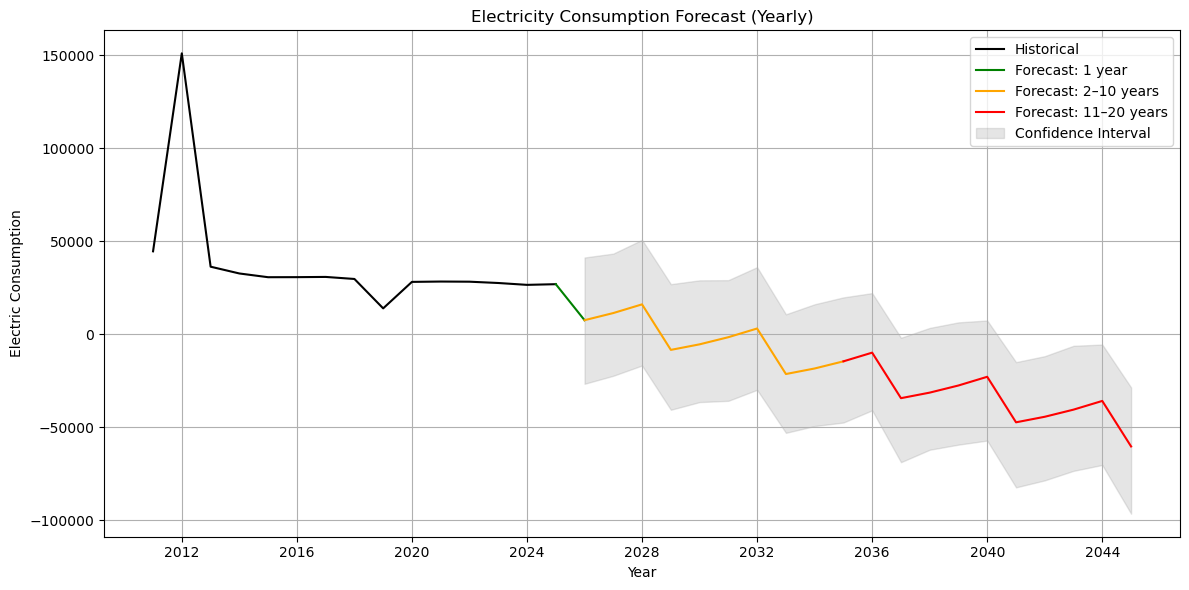

In [ ]:
# result = forecast_time_series(df_yearly)

In [206]:
#  detect frequency
def check_frequency(df):
    if df['ds'].dt.freq == 'ME':
        return 'M'
    elif df['ds'].dt.freq == 'YE-DEC':
        return 'Y'
    else:
        return '0'

# get forecast horizon by freq
def get_forecast_horizon(freq):
    if freq == 'M':
        return [1, 6, 9]
    elif freq == 'Y':
        return [1, 10, 20]
    else:
        raise ValueError(f"Unsupported frequency: {freq}")

# handle interpolation for yearly data
def interpolate_yearly_data(df):
    # Interpolate missing data for yearly frequency
    df = df.set_index('ds').resample('Y').mean()  # Ensure data is indexed by 'ds' (date)
    df['y'] = df['y'].interpolate(method='linear')  # Linear interpolation for missing values
    df = df.reset_index()  # Reset index after interpolation
    return df

# fit model and forecast
def fit_and_forecast(df, freq, periods, **prophet_kwargs):
    if freq == 'Y':  # For yearly data, interpolate and train on full data
        df = interpolate_yearly_data(df)
        model = Prophet(**prophet_kwargs)
        model.fit(df)
        future = model.make_future_dataframe(periods=periods[-1], freq='Y')  # Forecasting yearly
    else:  # For monthly data, use the existing method
        model = Prophet(**prophet_kwargs)
        model.fit(df)
        future = model.make_future_dataframe(periods=periods[-1], freq=freq)  # Forecasting monthly
    
    forecast = model.predict(future)
    return forecast, model

# plot forecast with color segments
def plot_forecast(train_df, val_df, forecast_val, forecast_future, freq):

    # plot setup
    plt.figure(figsize=(14, 6))
    if freq == 'M':
        plt.plot(train_df['ds'], train_df['y'], color='black', label='Train (Actual)')
        plt.plot(val_df['ds'], val_df['y'], color='gray', label='Validation (Actual)', linestyle='dashed')

        # plot validation forecast if available and well-formed
        plt.plot(forecast_val['ds'], forecast_val['yhat'], color='blue', label='Validation Forecast')
        plt.fill_between(forecast_val['ds'],
                        forecast_val['yhat_lower'],
                        forecast_val['yhat_upper'],
                        color='blue', alpha=0.2, label='Validation CI')
    else:
        plt.plot(train_df['ds'], train_df['y'], color='black', label='Train (Actual)')
        plt.plot(forecast_val['ds'], forecast_val['yhat'], color='blue', label='Training Forecast')
        plt.fill_between(forecast_val['ds'],
                        forecast_val['yhat_lower'],
                        forecast_val['yhat_upper'],
                        color='blue', alpha=0.2, label='Training CI')

    
    # forecast line for future
    forecast_line = forecast_future[['ds', 'yhat']]

    # plot future forecast in segments
    if freq == 'M':
        slices = [2, 7, 10]
        labels = ['1 month', '2–6 months', '7–9 months']
    elif freq == 'Y':
        slices = [2, 11, 21]
        labels = ['1 year', '2–10 years', '11–20 years']
    else:
        raise ValueError("Unsupported frequency")

    colors = ['green', 'orange', 'red']
    for i in range(3):
        start = slices[i - 1] - 1 if i > 0 else 0
        end = slices[i]
        plt.plot(forecast_line['ds'].iloc[start:end],
                 forecast_line['yhat'].iloc[start:end],
                 color=colors[i], label=f'Future Forecast: {labels[i]}')

    # plot future confidence interval
    plt.fill_between(forecast_future['ds'],
                     forecast_future['yhat_lower'],
                     forecast_future['yhat_upper'],
                     color='gray', alpha=0.3, label='Future CI')

    # final plot settings
    plt.title('Electricity Consumption Forecast: Validation + Future')
    plt.xlabel('Date')
    plt.ylabel('Electric Consumption (EC)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# evaluate model
def evaluate_model(df, forecast):
    merged = pd.merge(df, forecast[['ds', 'yhat']], on='ds', how='left')
    merged = merged.dropna(subset=['yhat'])  # drop rows without prediction

    y_true = merged['y']
    y_pred = merged['yhat']

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"\nModel Evaluation:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2%}")

# combine forecast outputs
def combine_forecast_outputs(train_df, val_df, forecast_val, forecast_future):
    # mark source for context
    train_df = train_df.copy()
    val_df = val_df.copy()
    forecast_val = forecast_val.copy()
    forecast_future = forecast_future.copy()

    train_df['set'] = 'train_actual'
    val_df['set'] = 'validation_actual'
    forecast_val['set'] = 'validation_forecast'
    forecast_future['set'] = 'future_forecast'

    # align columns
    df_train = train_df[['ds', 'y', 'set']]
    df_val = val_df[['ds', 'y', 'set']]
    df_fval = forecast_val[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    df_ffut = forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    df_fval['set'] = 'validation_forecast'
    df_ffut['set'] = 'future_forecast'

    df_fval = df_fval.rename(columns={'yhat': 'y', 'yhat_lower': 'lower', 'yhat_upper': 'upper'})
    df_ffut = df_ffut.rename(columns={'yhat': 'y', 'yhat_lower': 'lower', 'yhat_upper': 'upper'})

    # assign NaNs for missing cols
    df_train['lower'] = df_train['upper'] = None
    df_val['lower'] = df_val['upper'] = None

    # unify
    full_df = pd.concat([df_train, df_val, df_fval, df_ffut], ignore_index=True)
    return full_df.sort_values('ds').reset_index(drop=True)

# unified pipeline
def run_forecasting_pipeline(df, **prophet_kwargs):
    freq = check_frequency(df)
    # preprocess and split
    if freq == 'M':
        train_df, val_df = preprocess_and_split(df)
        print(f"Train range: {train_df['ds'].min().date()} -> {train_df['ds'].max().date()}")
        print(f"Validation range: {val_df['ds'].min().date()} -> {val_df['ds'].max().date()}")
    else:
        print(f"Train range: {df['ds'].min().date()} -> {df['ds'].max().date()}")

    # get forecast horizon
    periods = get_forecast_horizon(freq)

    # train model on training set only
    if freq == 'M':
        _, model = fit_and_forecast(train_df, freq, periods, **prophet_kwargs)
    else:
        _, model = fit_and_forecast(df, freq, periods, **prophet_kwargs)

    # predict on validation set range if available
    if freq == 'M':  # plot the validation set prediction
        future_val = val_df[['ds']].copy()
        forecast_val = model.predict(future_val)
        print("\nValidation Set Evaluation:")
        evaluate_model(val_df, forecast_val)
    else:
        past_val = df[['ds']].copy()
        forecast_val = model.predict(past_val)  # No validation forecast for yearly data
        print("\Training Set Evaluation:")
        evaluate_model(df, forecast_val)

    # retrain on full (train + validation) for future forecasting
    if freq == 'M':
        combined_df = pd.concat([train_df, val_df], ignore_index=True)
    else:
        combined_df = df

    final_model = Prophet(growth='linear')  # you can apply tuned params here
    final_model.fit(combined_df)

    # forecast into future from 2025 onward
    future_periods = periods[-1]  # longest horizon
    future_df = final_model.make_future_dataframe(periods=future_periods, freq=freq)
    forecast_future = final_model.predict(future_df)

    # extract only future portion
    if freq =='M':
        forecast_future = forecast_future[forecast_future['ds'] > val_df['ds'].max()].reset_index(drop=True)
    else:
        forecast_future = forecast_future[forecast_future['ds'] > df['ds'].max()].reset_index(drop=True)

    # print and plot final results
    print("\nFuture Forecast (from Jan 2025):")
    if freq == 'M':
        plot_forecast(train_df, val_df, forecast_val, forecast_future, freq)
    else:
        plot_forecast(df, None, forecast_val, forecast_future, freq)

    display(forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

    return final_model, forecast_future


Train range: 2012-01-31 -> 2017-12-31
Validation range: 2019-01-31 -> 2024-12-31


04:17:24 - cmdstanpy - INFO - Chain [1] start processing
04:17:24 - cmdstanpy - INFO - Chain [1] done processing
04:17:24 - cmdstanpy - INFO - Chain [1] start processing
04:17:24 - cmdstanpy - INFO - Chain [1] done processing



Validation Set Evaluation:

Model Evaluation:
R² Score: 0.8486
MAE: 1622.10
MAPE: 5.91%

Future Forecast (from Jan 2025):


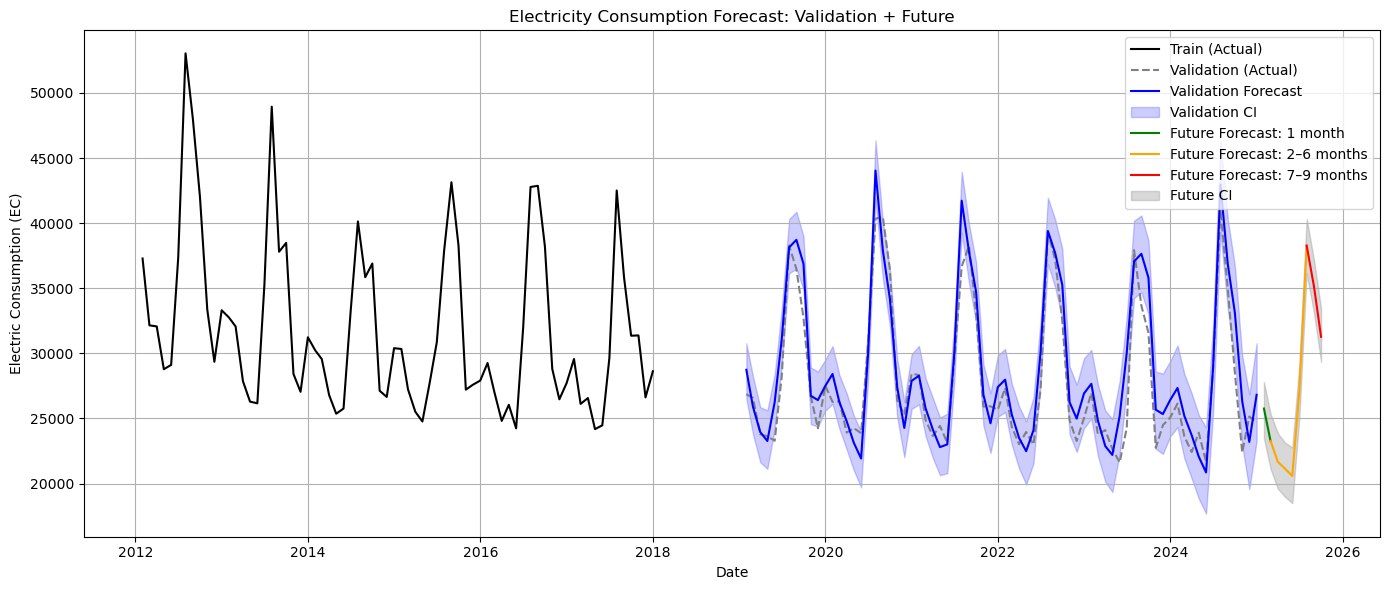

,ds,yhat,yhat_lower,yhat_upper
0,2025-01-31,25761.985377,23489.873696,27806.938910
1,2025-02-28,23273.640504,21136.302576,25363.245277
2,2025-03-31,21663.213247,19604.589247,23857.720551
3,2025-04-30,21151.120620,18988.341898,23156.953795
4,2025-05-31,20582.755317,18503.377807,22764.729469
5,2025-06-30,27111.668182,25051.897577,29177.082865
6,2025-07-31,38272.185382,36133.272447,40321.933915
7,2025-08-31,35130.123297,33109.021865,37173.822569
8,2025-09-30,31268.016773,29343.376257,33444.142539


04:17:25 - cmdstanpy - INFO - Chain [1] start processing


Train range: 2010-12-31 -> 2024-12-31


04:17:25 - cmdstanpy - INFO - Chain [1] done processing
04:17:25 - cmdstanpy - INFO - Chain [1] start processing
04:17:25 - cmdstanpy - INFO - Chain [1] done processing


\Training Set Evaluation:

Model Evaluation:
R² Score: 0.3069
MAE: 16968.77
MAPE: 46.79%

Future Forecast (from Jan 2025):


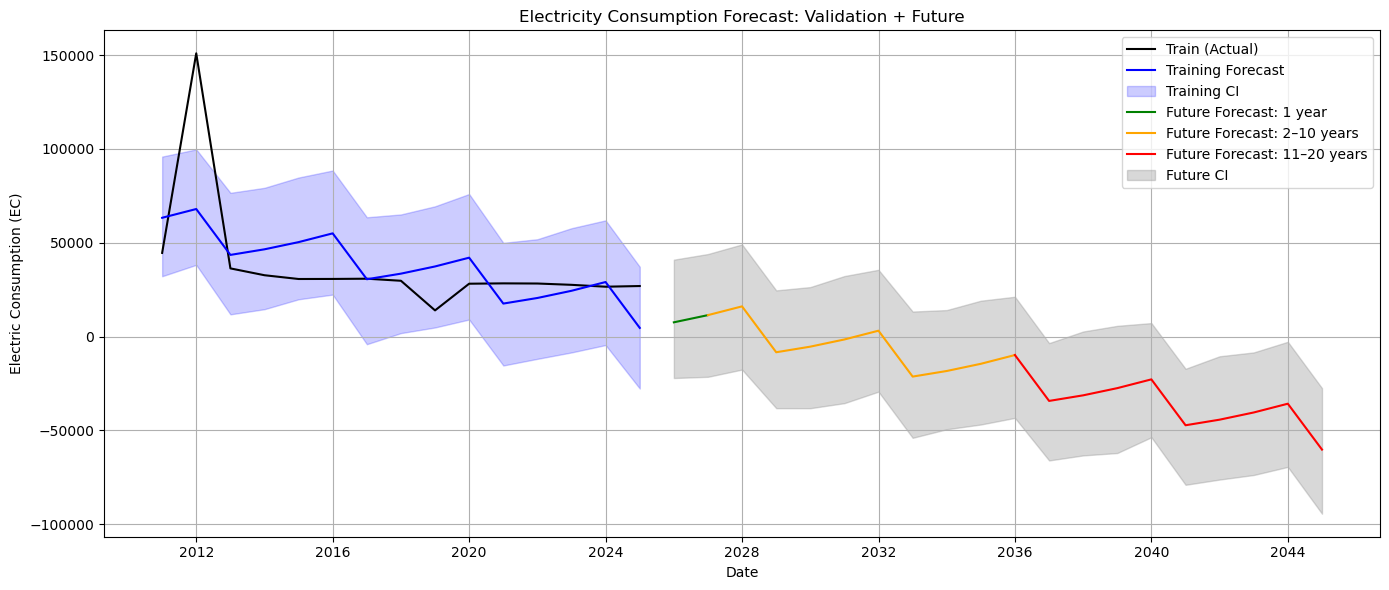

,ds,yhat,yhat_lower,yhat_upper
0,2025-12-31,7603.906359,-22095.959212,40998.056340
1,2026-12-31,11435.971813,-21447.686547,44005.605212
2,2027-12-31,16107.946362,-17593.650522,49127.562856
3,2028-12-31,-8352.617024,-38166.994711,24628.220676
4,2029-12-31,-5369.011127,-38176.910340,26384.645124
5,2030-12-31,-1536.945673,-35494.643192,32258.051735
6,2031-12-31,3135.028876,-29361.766024,35598.402189
7,2032-12-31,-21325.534510,-53969.250351,13343.445906
8,2033-12-31,-18341.928614,-49406.000042,14134.281425
9,2034-12-31,-14509.863160,-46873.121870,19123.160786


In [207]:
# for monthly data
forecast_monthly, model_monthly = run_forecasting_pipeline(df_monthly)

# for yearly data
forecast_yearly, model_yearly = run_forecasting_pipeline(df_yearly)


In [208]:
prophet_params = {
    'growth': 'linear',
    'changepoint_prior_scale': 0.001,
    'changepoint_range': 0.8
}

In [ ]:
# initialize and fit prophet model
model = Prophet()
model.fit(df_monthly)

# forecast 9 months into the future
future = model.make_future_dataframe(periods=9, freq='M')
forecast = model.predict(future)

# extract forecast points only
forecast_future = forecast[forecast['ds'] > df_monthly['ds'].max()].reset_index(drop=True)

# stitch last historical point to forecasted future for better visualization
last_hist_point = df_monthly[['ds', 'y']].iloc[-1]
last_point_df = pd.DataFrame({'ds': [last_hist_point['ds']], 'yhat': [last_hist_point['y']]})
forecast_future = forecast[forecast['ds'] > df_monthly['ds'].max()].reset_index(drop=True)
forecast_line = pd.concat([last_point_df, forecast_future[['ds', 'yhat']]], ignore_index=True)

# plot historical data
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['ds'], df_monthly['y'], color='black', label='Historical')

# plot stitched forecast in 3 colored segments
plt.plot(forecast_line['ds'].iloc[0:2], forecast_line['yhat'].iloc[0:2], color='green', label='Forecast: 1 month')
plt.plot(forecast_line['ds'].iloc[1:6], forecast_line['yhat'].iloc[1:6], color='orange', label='Forecast: 2–6 months')
plt.plot(forecast_line['ds'].iloc[5:], forecast_line['yhat'].iloc[5:], color='red', label='Forecast: 7–9 months')

# confidence interval
plt.fill_between(forecast_future['ds'],
                 forecast_future['yhat_lower'],
                 forecast_future['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')

# aesthetics
plt.title('Electricity Consumption Forecast (Monthly)')
plt.xlabel('Date')
plt.ylabel('Electric Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prohpet Predictions

## Fitting model for monthly data

In [ ]:
def preprocess_and_split(df):
    # convert date to datetime if needed
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds').reset_index(drop=True)

    # drop rows with missing target values
    df = df.dropna(subset=['y'])

    # apply split
    train_df = df[(df['ds'] >= '2012-01-01') & (df['ds'] <= '2017-12-31')].copy()
    val_df = df[(df['ds'] >= '2019-01-01') & (df['ds'] <= '2024-12-31')].copy()

    return train_df, val_df

In [ ]:
# plotting predictions
def plot_forecast(train, test, forecast):

    test = test.reset_index()
    test.rename(columns={'Date': 'ds', 'EC': 'y'}, inplace=True)

    predictions = forecast[forecast['ds'] >= test['ds'].min()] #test+forecast

    plt.figure(figsize=(12, 6))

    plt.plot(train['ds'], train['y'], label='Training Set', color='blue')
    plt.plot(test['ds'], test['y'], label='Testing Set (Validation)', color='green')
    plt.plot(predictions['ds'], predictions['yhat'], label='Forecast', color='orange')
    plt.fill_between(predictions['ds'],predictions['yhat_lower'],predictions['yhat_upper'],color='orange', alpha=0.3, label='Confidence Interval')

    plt.title('Prophet Forecast for Electric Consumption')
    plt.xlabel('Year')
    plt.ylabel('Consumption (KWH)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# prophet prediction function
def prophet_prediction(train,test,p,f):
    model = Prophet()
    train = train.reset_index()
    model.fit(train)
    future = model.make_future_dataframe(periods=int(p), freq=f)
    forecast = model.predict(future)
    
    plot_forecast(train, test, forecast)

In [168]:
train_df, val_df = preprocess_and_split(df_monthly)

03:18:06 - cmdstanpy - INFO - Chain [1] start processing
03:18:06 - cmdstanpy - INFO - Chain [1] done processing


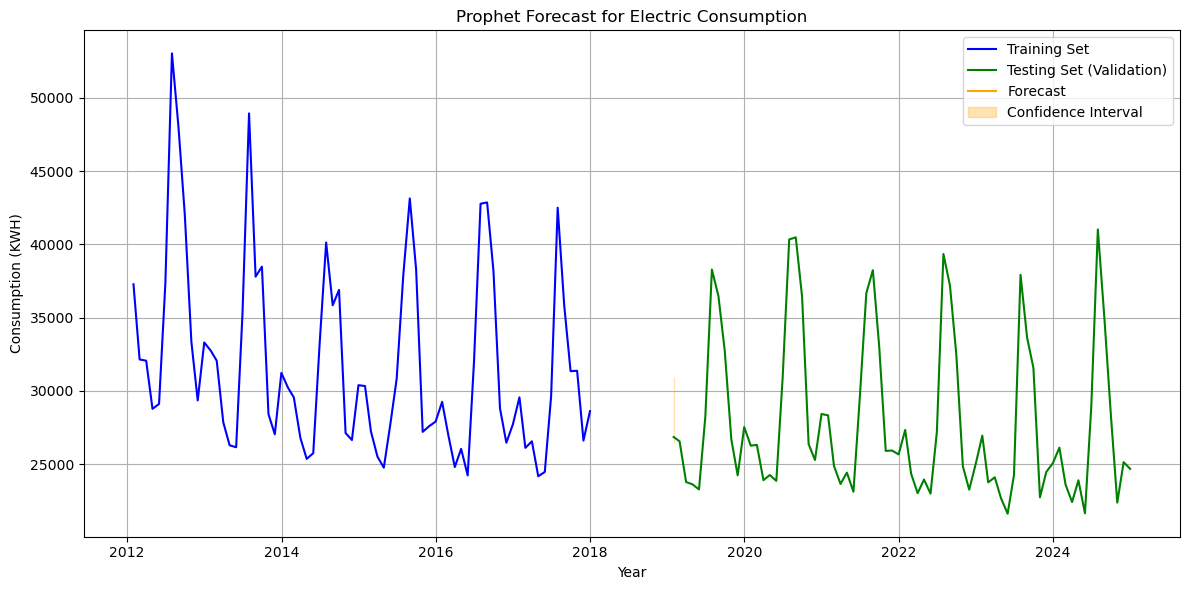

In [172]:
# Predictions for 12 months of validation + 1 month in future with default growth as linrear
prophet_prediction(train_df, val_df,13, 'M')

In [ ]:
# Predictions for 12 months of validation + 6 month in future with default growth as linrear
prophet_prediction(train_monthly, test_monthly,18, 'M')

In [ ]:
# Predictions for 12 months of validation + 9 month in future with default growth as linrear
prophet_prediction(train_monthly, test_monthly,21, 'M')

# <center>Performing the model for Yearly Predictions

### Splitting the data into train and test sets for yearly data

In [ ]:
df_yearly

In [ ]:
train_yearly = df_yearly[(df_yearly.index >= '2010-01-01') & (df_yearly.index <= '2024-12-31')]
# test_yearly = df_yearly[(df_yearly.index >= '2023-12-31') & (df_yearly.index < '2025-01-01')]

In [ ]:
# train_monthly = df_monthly[(df_monthly.index >= '2019-01-31') & (df_monthly.index <= '2023-12-31')]
# test_monthly = df_monthly[(df_monthly.index >= '2023-12-31') & (df_monthly.index < '2025-01-01')]

In [ ]:
# Plotting test and train for mo ywarly data
plt.figure(figsize=(12, 6))
plt.plot(train_yearly.index, train_yearly['EC'], label='Train')
# plt.xticks([i for i in range(2010, 2025, 1)])
# plt.plot(test_yearly.index, test_yearly['EC'], label='Test')
plt.title('Train and Test Set for Yearly Data')
plt.xlabel('Date')
plt.ylabel('Consumption (KWH)')
plt.legend()
plt.show()

### Fitting model for yearly data

In [ ]:
# Predictions for 1 year of validation + 1 year in future with default growth as linrear
prophet_prediction(train_yearly, test_yearly,2, 'Y')

In [ ]:
# Predictions for 1 year of validation + 10 year in future with default growth as linrear
prophet_prediction(train_yearly, test_yearly,11, 'Y')

In [ ]:
# Predictions for 1 year of validation + 20 year in future with default growth as linrear
prophet_prediction(train_yearly, test_yearly,21, 'Y')

## <center>Performing the model for Monthly Predictions with Flat growth

In [ ]:
def prophet_prediction_flat_simul(train,test,p,f):
    model = prophet.Prophet(growth='linear', changepoint_prior_scale=0.001,n_changepoints=0)                
    train = train.reset_index()
    train.rename(columns={'Date': 'ds', 'EC': 'y'}, inplace=True)
    model.fit(train)
    future = model.make_future_dataframe(periods=int(p), freq=f)
    forecast = model.predict(future)
    
    plot_forecast(train, test, forecast)

In [ ]:
prophet_prediction_flat_simul(train_monthly, test_monthly,13, 'M')

In [ ]:
prophet_prediction_flat_simul(train_monthly, test_monthly,18, 'M')

In [ ]:
prophet_prediction_flat_simul(train_monthly, test_monthly,21, 'M')

## <center>Performing the model for Yearly Predictions with Flat growth

In [ ]:
prophet_prediction(train_yearly, test_yearly,2, 'Y')

In [ ]:
prophet_prediction(train_yearly, test_yearly,11, 'Y')

In [ ]:
prophet_prediction(train_yearly, test_yearly,21, 'Y')

# <center>Performing the model for Monthly Predictions with Logistic growth

In [ ]:
# Funcation to predict with logistic growth
def prophet_prediction_logistic(train, test, p, f, cap_value=None):

    # Prepare training data
    train = train.reset_index()
    train.rename(columns={'Date': 'ds', 'EC': 'y'}, inplace=True)

    # Set default or custom cap
    if cap_value is None:
        cap_value = train['y'].max() * 1.2
    train['cap'] = cap_value

    # Build and fit model
    model = prophet.Prophet(growth='logistic')
    model.fit(train)

    # Create future dataframe and set same cap
    future = model.make_future_dataframe(periods=int(p), freq=f)
    future['cap'] = cap_value

    # Forecast
    forecast = model.predict(future)

    # Plot
    plot_forecast(train, test, forecast)


In [ ]:
prophet_prediction_logistic(train_monthly, test_monthly,13, 'M')

In [ ]:
prophet_prediction_logistic(train_monthly, test_monthly,18, 'M')

In [ ]:
prophet_prediction_logistic(train_monthly, test_monthly,21, 'M')

# <center>Performing the model for Yearly Predictions with Logistic growth

In [ ]:
prophet_prediction_logistic(train_yearly, test_yearly,2, 'Y')

In [ ]:
prophet_prediction_logistic(train_yearly, test_yearly,11, 'Y')

In [ ]:
prophet_prediction_logistic(train_yearly, test_yearly,21, 'Y')